In [2]:
from astrodendro import Dendrogram, pp_catalog
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import regions
import numpy as np
from astropy import coordinates
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import QTable, Table, Column
import matplotlib.cm as cm
from pyregion.mpl_helper import properties_func_default
from astropy.visualization import simple_norm
from astropy.stats import mad_std
#from regions import DS9Parser
import re
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import warnings
from astropy import visualization
from astropy.stats import mad_std
from astropy.io import ascii
# from astropy.table import Table
import regions

ModuleNotFoundError: No module named 'astropy'

In [4]:
pwd

'/home/nbudaiev/SgrB2_ALMA_continuum'

In [2]:
cd

/home/nbudaiev


In [3]:
cd /orange/adamginsburg/sgrb2/NB

/orange/adamginsburg/sgrb2/NB


In [4]:
def read_in(path):
    """
    Simplify reading in the files.
    """
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
    data=fh[0].data
    return data, wcs

In [5]:
def basefigure(data):
    """
    Set up basefigure for plotting the data. 
    """
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(projection=wcs_out)
    im = ax.imshow(data, cmap='gray_r', norm=norm1)
    
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([ax.get_position().x1-0.1,
        ax.get_position().y0,
        0.02,
        ax.get_position().height])

    cb = plt.colorbar(mappable=im, cax=cax)
    cb.ax.tick_params(labelsize=tick_fontsize)
    ax.axis([167,1617,210,1618]) # The original images nave a few extra NaN rows and columns.

    
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    radesys = wwM.wcs.radesys
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    ax.axis([0,7719,0,10579])
    return fig, ax

In [6]:
def set_up_regions(path,wX):
    """
    Modifies a CASA-created DS9 region file to a version that works with Astrodendro package.
    Adds 'source_X' text to each region, where X is a source number based on its RA.
    
    Outputs:
    includeX: original DS9 regions
    regionsX: modified version of DS9 regions that works with Astrodendro
    pixelX: same as regionsX, but with pixel coordinates.
    """
    includeX = regions.Regions.read(path)
    strX = regions.Regions.serialize(includeX, format='ds9')
    start = []
    for m in re.finditer('source=1', strX):
        start += [m.end()]
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        strM = strX[:loc] + ' text={source_' + x +'}' + strX[loc:]
    parser = regions.Regions.parse(strX, format='ds9')
    regionsX = parser.serialize(format='ds9')
    #regions.write_ds9(regionsX, 'regionsX_text.reg')
    pixelX = [region.to_pixel(wX) for region in includeX]
    return includeX, regionsX, pixelX

In [7]:
# TEST = []
# for i in range(len(cat['_idx'])):
#     if cat['_idx'][i] in cat_final['_idx']:
#         TEST+=[1]
#     else:
#         TEST+=[0]

In [8]:
def set_up_catalog(d,wX,includeX,central=False):
    """
    Creates a dendrogram catalog.
    Removes sources that are not inside includeX regions.
    Removes sources that are above level 5 in the dendrogram (removes some unwated 
    detections from extended structures).
    """
    cat = pp_catalog(d.leaves,metadata={'data_unit':u.Jy,'wcs': wX},verbose=False)
    print('Total detections: '+str(len(d.leaves)))
    purgeX = []
    for i in range(len(d)):
        if d[i].level > 5: 
            purgeX += [d[i].idx]
    coordsX = coordinates.SkyCoord(cat['x_cen'], cat['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    containsX = np.zeros(len(cat),dtype=bool)
    for X in includeX:
        containsX[X.contains(coordsX, wX)] = 1
    print('Total detections inside input regions: '+str(np.sum(containsX)))
    cat_cut = cat[containsX]
    
    if central:
        print('Central region. No trimming performed')
        cat_coords = coordinates.SkyCoord(cat_cut['x_cen'], cat_cut['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_cut, cat_cut['_idx']
    else:
        cat_final= cat_cut[:0].copy()
        for i in range(len(cat_cut)):    
            if cat_cut['_idx'][i] not in purgeX:
                cat_final.add_row(cat_cut[i])
        print('Total detections after triming above level 5: '+str(len(cat_final)))
        cat_coords = coordinates.SkyCoord(cat_final['x_cen'], cat_final['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_final, cat_final['_idx']

In [9]:
def regions_gaussfit(cat_final):
    """
    Creates a DS9 region file from the catalog. The centers and sizes of each region
    are based on ['x_cen'], ['y_cen'], and ['radius'] columns in the catalog.
    """
    centerX = SkyCoord(cat_final['x_cen'], cat_final['y_cen'],unit='deg')
    # There are some problems with displaying these regions in DS9.
    # Use 1st option to display the regions in DS9.
    # Use 2nd option to have proper radii for later use.
    radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
    #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    cat_regionsX = []
    for i in range(len(centerX)):
        cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
    str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX)
    start = []
    for m in re.finditer('\)', str_cat_regionsX):
        start += [m.end()]
    str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
    str2 = '}'
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
    parser = DS9Parser(str_cat_regionsX)
    str_cat_regionsX = parser.shapes.to_regions()
    regions.write_ds9(str_cat_regionsX, "regionsN_text_degrees.reg")
    #return str_cat_regionsX

In [10]:
def makefig(data,catX_pixel,pixelX,xl=0,xu=9999,yl=0,yu=9999,plotsources=True):
    if xu == 9999:
        xu = len(data)
        yu = len(data)
    mad = mad_std(data, ignore_nan=True)
    norm = visualization.simple_norm(data, stretch='linear', min_cut=-3*mad, max_cut=8*mad,)
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8])
    fig.add_axes(ax)
    ax.axis([xl,xu,yl,yu])
    ax.imshow(data, cmap='Greys', norm=norm, origin="lower")

    cm = plt.cm.get_cmap('inferno')
    cm.set_under((0,0,0,0))
    vmin = norm.vmax*0.99
    norm2 = visualization.simple_norm(data, min_cut=vmin, stretch='log', max_percent=100)
    norm2.vmin = vmin
    im2 = ax.imshow(data, cmap='inferno',norm=norm2)
    
    
    if plotsources:
        ax.plot(catX_pixel[0],catX_pixel[1],'X',alpha=1,color='aqua')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            for region in pixelX: 
                region.plot(color='green',alpha=1,fill=False)

2300,2800,400,900 DS

2500,3000,1500,1800 #MN

2600,3000,2400,3000 #N

2400,3000,2400,3000 #M

In [11]:
pathN='NB.sgr_b2.N.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'
pathM='NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'

In [12]:
#pathM='NB.sgr_b2.M.B6.cont.pb0.1.r0.5.clean100k2mjy_pcal2.image.tt0.pbcor.fits'
#pathN='NB.sgr_b2.N.B6.cont.pb0.1.r0.5.clean100k2mjy_pcal2.image.tt0.pbcor.fits'

In [13]:
Ncal, wN = read_in(pathN)
Mcal, wM = read_in(pathM)

In [14]:
Ncal.shape

(5488, 5488)

In [15]:
regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
#regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_center.reg'
regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_regions.reg'
#regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_center.reg'

In [16]:
includeM, regionsM, pixelM = set_up_regions(regionsM_path,wM)
includeN, regionsN, pixelN = set_up_regions(regionsN_path,wN)

In [17]:
dN = Dendrogram.compute(Ncal, min_value = 0.00015, min_delta=0.00005, min_npix = 15) # Outside the center
dM = Dendrogram.compute(Mcal, min_value = 0.00015, min_delta=0.0001, min_npix = 15) # Outside the center
#dM = Dendrogram.compute(Mcal, min_value = 0.0001, min_delta=0.0003, min_npix = 10) # Central region
#dN = Dendrogram.compute(Ncal, min_value = 0.0001, min_delta=0.0001, min_npix = 10) # Central region

#dN = Dendrogram.compute(Ncal, min_value = 0.0005, min_delta=0.0002, min_npix = 50) # Outside the center B6
#dM = Dendrogram.compute(Mcal, min_value = 0.0005, min_delta=0.0002, min_npix = 50) # Outside the center B6

In [18]:
cat_coordsM, cat_finalM, IDsM = set_up_catalog(dM,wM,includeM,central=True)

Total detections: 11784
Total detections inside input regions: 184
Central region. No trimming performed


In [19]:
cat_coordsN, cat_finalN, IDsN = set_up_catalog(dN,wN,includeN,central=True)

Total detections: 11168
Total detections inside input regions: 129
Central region. No trimming performed


In [20]:
cat_finalM.remove_columns(cat_finalM.colnames[1:])
cat_finalN.remove_columns(cat_finalN.colnames[1:])
#ascii.write(cat_finalM, 'IDsM.csv', overwrite=True,format='csv')
#ascii.write(cat_finalN, 'IDsN.csv', overwrite=True,format='csv')

In [21]:
catM_pixel = wM.world_to_pixel(cat_coordsM)
catN_pixel = wN.world_to_pixel(cat_coordsN)

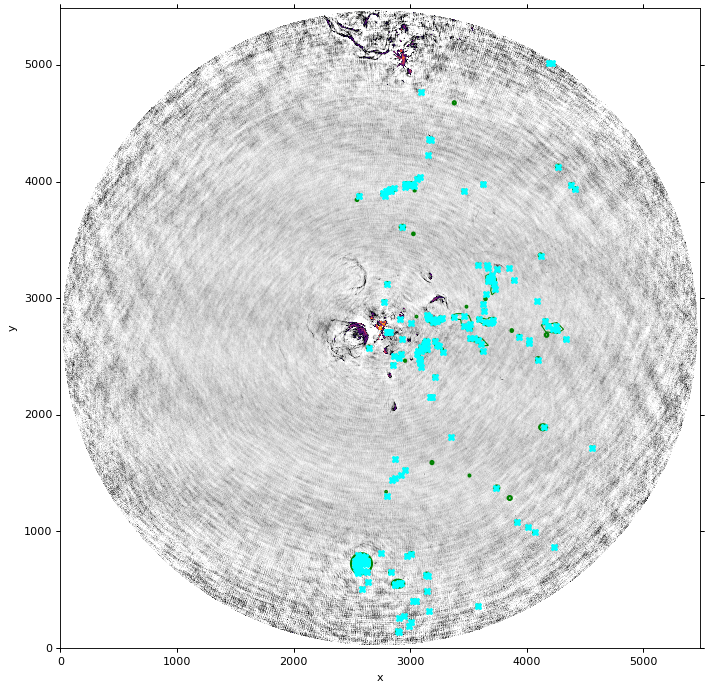

In [34]:
makefig(Mcal,catM_pixel,pixelM)

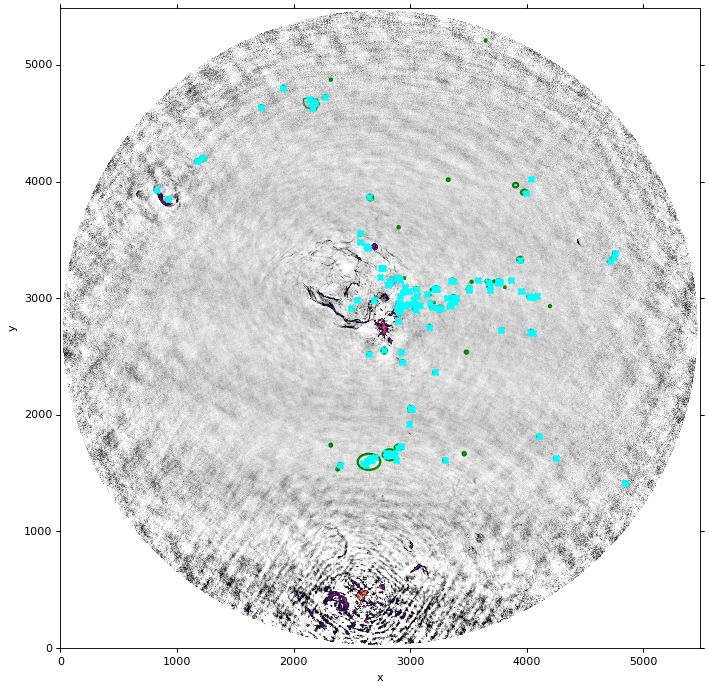

In [22]:
makefig(Ncal,catN_pixel,pixelN)

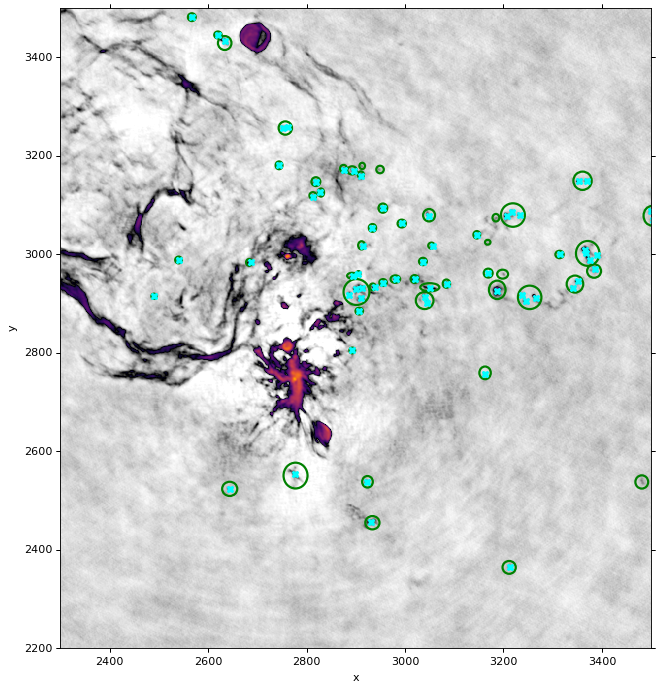

In [23]:
makefig(Ncal,catN_pixel,pixelN,2300,3500,2200,3500,plotsources=True)

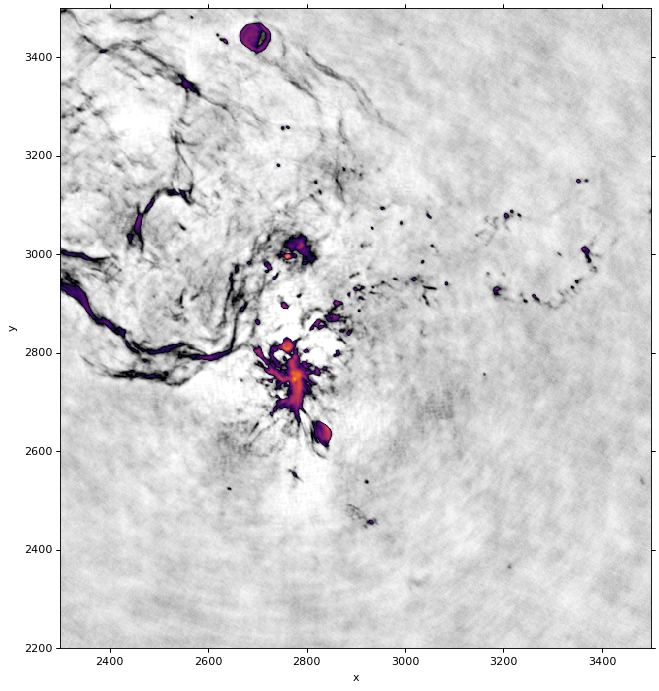

In [24]:
makefig(Ncal,catN_pixel,pixelN,2300,3500,2200,3500,plotsources=False)

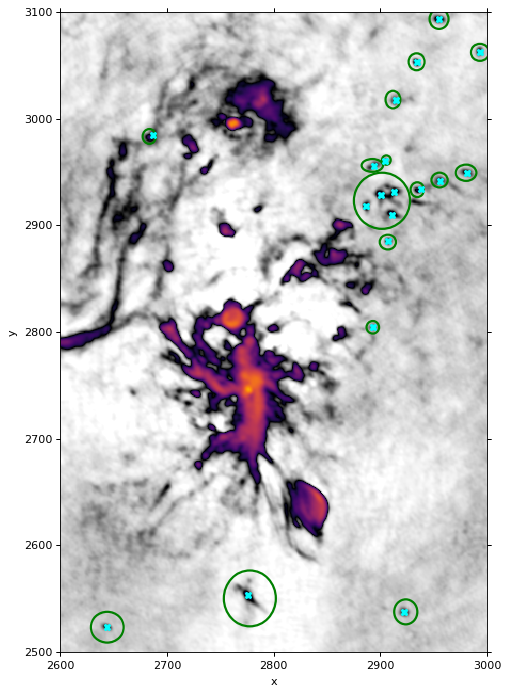

In [25]:
makefig(Ncal,catN_pixel,pixelN,2600,3000,2500,3100,plotsources=True)

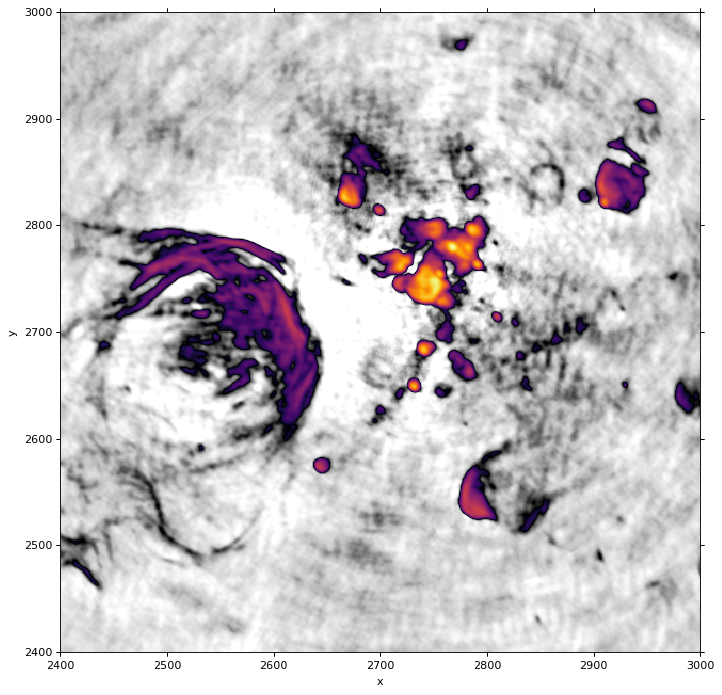

In [26]:
makefig(Mcal,catM_pixel,pixelM,2400,3000,2400,3000,plotsources=False)

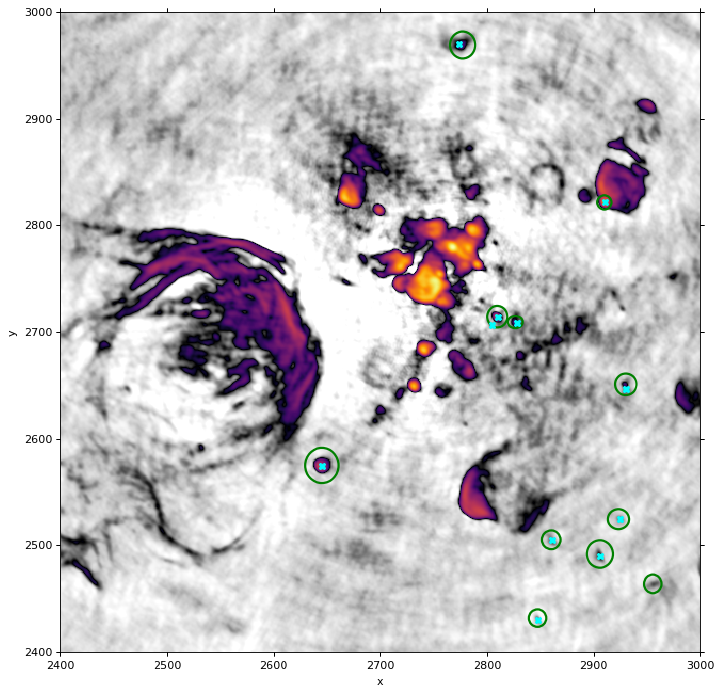

In [27]:
makefig(Mcal,catM_pixel,pixelM,2400,3000,2400,3000)

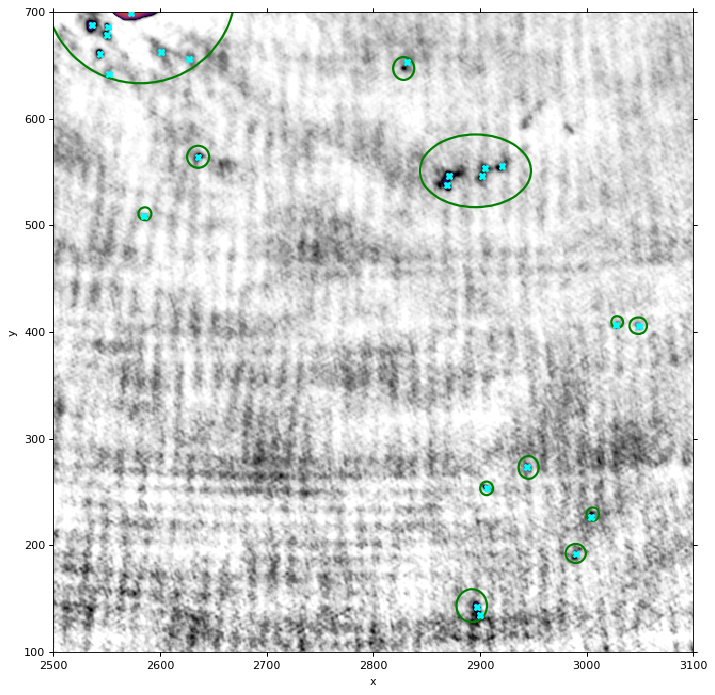

In [28]:
makefig(Mcal,catM_pixel,pixelM,2500,3100,100,700)

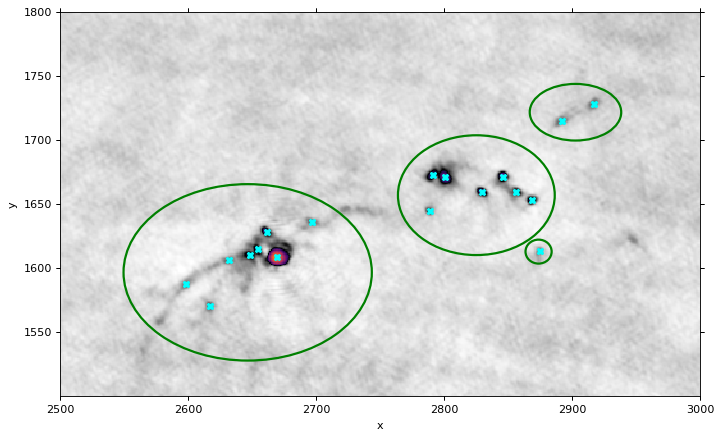

In [29]:
makefig(Ncal,catN_pixel,pixelN,2500,3000,1500,1800,plotsources=True)

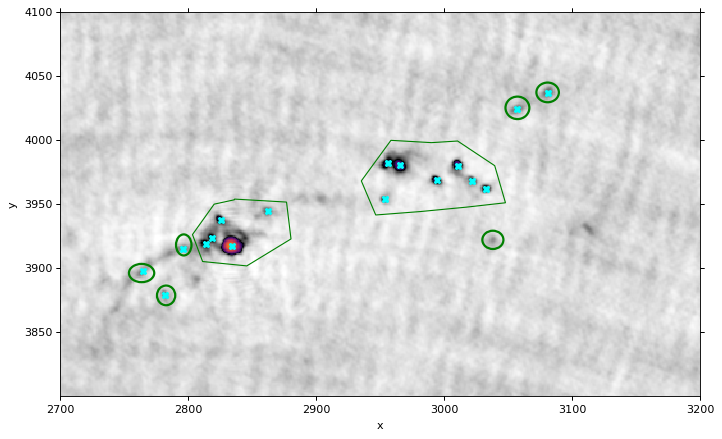

In [30]:
makefig(Mcal,catM_pixel,pixelM,2700,3200,3800,4100)

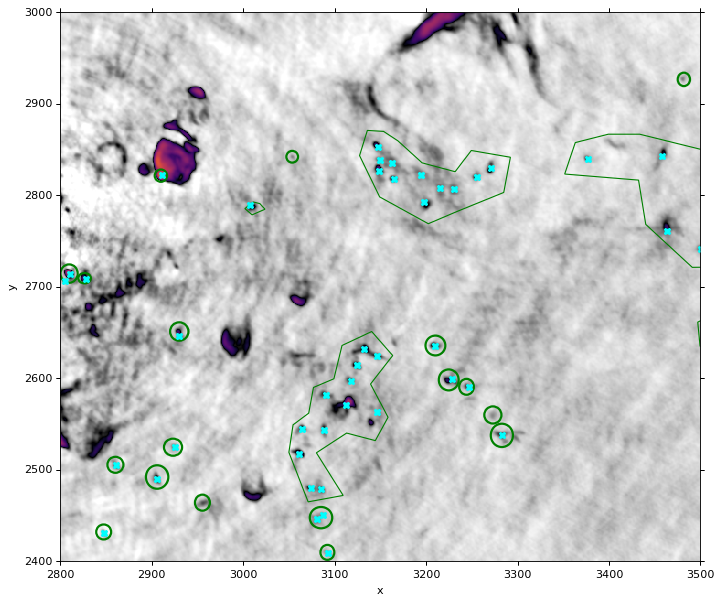

In [31]:
makefig(Mcal,catM_pixel,pixelM,2800,3500,2400,3000,plotsources=True)

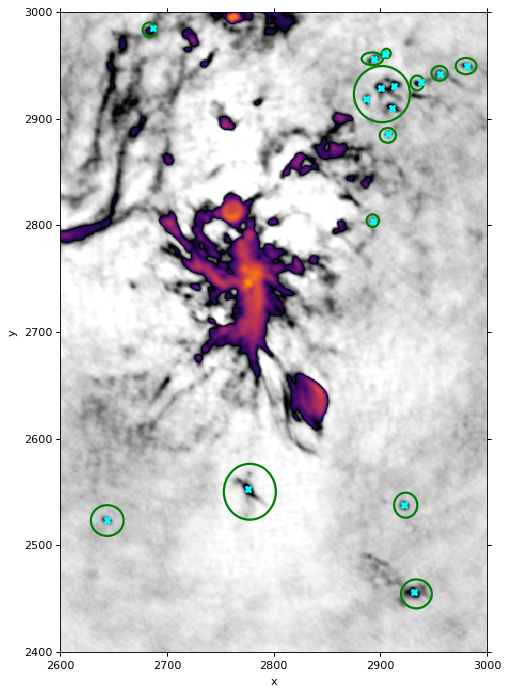

In [32]:
makefig(Ncal,catN_pixel,pixelN,2600,3000,2400,3000)

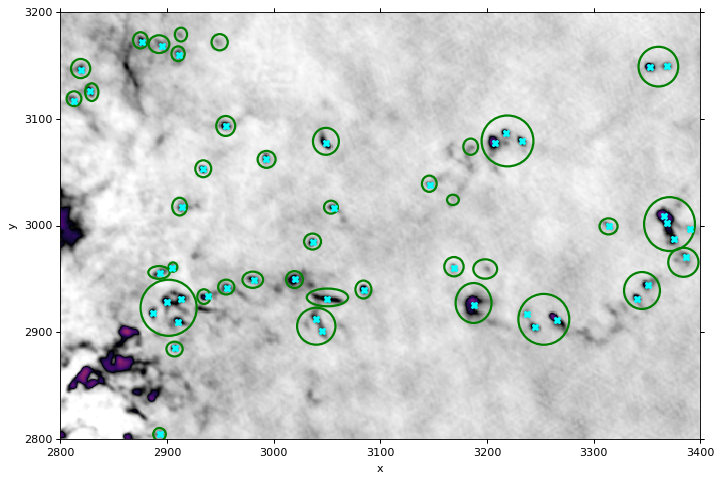

In [33]:
makefig(Ncal,catN_pixel,pixelN,2800,3400,2800,3200)